In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [15]:
file_path = ''
data = pd.read_csv(file_path)
f"Размер исходного набора данных: {data.shape}"

'Размер исходного набора данных: (3075, 12)'

In [16]:
# Кодирование категориальных переменных
le = LabelEncoder()
data['Is declined'] = le.fit_transform(data['Is declined'])
data['isForeignTransaction'] = le.fit_transform(data['isForeignTransaction'])
data['isHighRiskCountry'] = le.fit_transform(data['isHighRiskCountry'])
data['isFradulent'] = le.fit_transform(data['isFradulent'])

In [17]:
# Заполнение пропущенных значений в числовых столбцах медианой
numeric_columns = ['Average Amount/transaction/day', 'Transaction_amount',
                   'Total Number of declines/day', 'Daily_chargeback_avg_amt',
                   '6_month_avg_chbk_amt', '6-month_chbk_freq']
for col in numeric_columns:
    data[col] = data[col].fillna(data[col].median())

In [18]:
# Нормализация числовых признаков
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [19]:
# Проверка баланса классов
print("Распределение классов в isFradulent:")
print(data['isFradulent'].value_counts())

# Выбор признаков и целевой переменной
features = ['Average Amount/transaction/day', 'Transaction_amount', 'Is declined',
            'Total Number of declines/day', 'isForeignTransaction', 'isHighRiskCountry',
            'Daily_chargeback_avg_amt', '6_month_avg_chbk_amt', '6-month_chbk_freq']
X = data[features]
y = data['isFradulent']

Распределение классов в isFradulent:
isFradulent
0    2627
1     448
Name: count, dtype: int64


In [20]:
# Стратифицированное разделение данных
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    print(f"Размер обучающей выборки: {X_train.shape}, тестовой выборки: {X_test.shape}")
except ValueError as e:
    print(f"Ошибка при разделении данных: {e}")
    exit()

Размер обучающей выборки: (2460, 9), тестовой выборки: (615, 9)


In [21]:
# Применение SMOTE для балансировки классов
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(f"Размер обучающей выборки после SMOTE: {X_train.shape}")

Размер обучающей выборки после SMOTE: (4204, 9)


In [22]:
# Реализация генетического алгоритма
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations, elite_size=2):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.elite_size = elite_size
        self.population = None
        self.fitness_history = []

    def initialize_population(self, n_features):
        # Каждый индивид — набор порогов для признаков
        self.population = np.random.uniform(-3, 3, (self.population_size, n_features))  # Пороги для нормализованных данных

    def evaluate_fitness(self, X, y, individual, feature_ranges):
        thresholds = individual  # Пороги уже в масштабе нормализованных данных
        predictions = np.zeros(len(X))
        for idx, (_, row) in enumerate(X.iterrows()):
            score = 0
            for j, feature in enumerate(features):
                if feature in ['Is declined', 'isForeignTransaction', 'isHighRiskCountry']:
                    if row[feature] < thresholds[j]:
                        score += 1
                else:
                    if row[feature] > thresholds[j]:
                        score += 1
            predictions[idx] = 1 if score >= 4 else 0  # Фиксированный порог: 4 из 9 признаков
        return f1_score(y, predictions, zero_division=0)

    def select_parents(self, fitness):
        tournament_size = 5
        selected = []
        for _ in range(self.population_size - self.elite_size):
            tournament = np.random.choice(range(self.population_size), tournament_size)
            best_idx = tournament[np.argmax([fitness[i] for i in tournament])]
            selected.append(self.population[best_idx])
        return np.array(selected)

    def crossover(self, parents):
        offspring = []
        for i in range(0, len(parents), 2):
            parent1, parent2 = parents[i], parents[i+1 if i+1 < len(parents) else 0]
            crossover_point = np.random.randint(1, len(parent1)-1)
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring.extend([child1, child2])
        return np.array(offspring[:self.population_size - self.elite_size])

    def mutate(self, offspring, generation):
        current_mutation_rate = self.mutation_rate * (1 - generation / self.generations)
        for individual in offspring:
            for i in range(len(individual)):
                if np.random.rand() < current_mutation_rate:
                    individual[i] = np.random.uniform(-3, 3)  # Мутация в масштабе нормализованных данных
        return offspring

    def fit(self, X, y):
        feature_ranges = [(-3, 3)] * len(features)  # Диапазон для нормализованных данных
        self.initialize_population(len(features))

        for generation in range(self.generations):
            fitness = [self.evaluate_fitness(X, y, ind, feature_ranges) for ind in self.population]
            self.fitness_history.append(max(fitness))

            elite_indices = np.argsort(fitness)[-self.elite_size:]
            elite = self.population[elite_indices].copy()

            parents = self.select_parents(fitness)
            offspring = self.crossover(parents)
            offspring = self.mutate(offspring, generation)
            self.population = np.vstack((elite, offspring))

            print(f'Поколение {generation+1}/{self.generations}, Лучшая F1-оценка: {max(fitness):.4f}')

        best_idx = np.argmax([self.evaluate_fitness(X, y, ind, feature_ranges) for ind in self.population])
        return self.population[best_idx], feature_ranges

    def predict(self, X, best_individual, feature_ranges):
        thresholds = best_individual
        predictions = np.zeros(len(X))
        for idx, (_, row) in enumerate(X.iterrows()):
            score = 0
            for j, feature in enumerate(features):
                if feature in ['Is declined', 'isForeignTransaction', 'isHighRiskCountry']:
                    if row[feature] < thresholds[j]:
                        score += 1
                else:
                    if row[feature] > thresholds[j]:
                        score += 1
            predictions[idx] = 1 if score >= 4 else 0
        return predictions

In [23]:
# Инициализация и запуск генетического алгоритма
ga = GeneticAlgorithm(population_size=100, mutation_rate=0.2, generations=100, elite_size=5)
best_individual, feature_ranges = ga.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred = ga.predict(X_test, best_individual, feature_ranges)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f'Точность на тесте: {precision:.4f}')
print(f'Полнота на тесте: {recall:.4f}')
print(f'F1-оценка на тесте: {f1:.4f}')

Поколение 1/100, Лучшая F1-оценка: 0.8533
Поколение 2/100, Лучшая F1-оценка: 0.8533
Поколение 3/100, Лучшая F1-оценка: 0.8533
Поколение 4/100, Лучшая F1-оценка: 0.8533
Поколение 5/100, Лучшая F1-оценка: 0.8606
Поколение 6/100, Лучшая F1-оценка: 0.8637
Поколение 7/100, Лучшая F1-оценка: 0.8637
Поколение 8/100, Лучшая F1-оценка: 0.8637
Поколение 9/100, Лучшая F1-оценка: 0.8637
Поколение 10/100, Лучшая F1-оценка: 0.8637
Поколение 11/100, Лучшая F1-оценка: 0.8637
Поколение 12/100, Лучшая F1-оценка: 0.8671
Поколение 13/100, Лучшая F1-оценка: 0.8671
Поколение 14/100, Лучшая F1-оценка: 0.8671
Поколение 15/100, Лучшая F1-оценка: 0.8671
Поколение 16/100, Лучшая F1-оценка: 0.8671
Поколение 17/100, Лучшая F1-оценка: 0.8676
Поколение 18/100, Лучшая F1-оценка: 0.8686
Поколение 19/100, Лучшая F1-оценка: 0.8686
Поколение 20/100, Лучшая F1-оценка: 0.8686
Поколение 21/100, Лучшая F1-оценка: 0.8686
Поколение 22/100, Лучшая F1-оценка: 0.8689
Поколение 23/100, Лучшая F1-оценка: 0.8692
Поколение 24/100, Лу

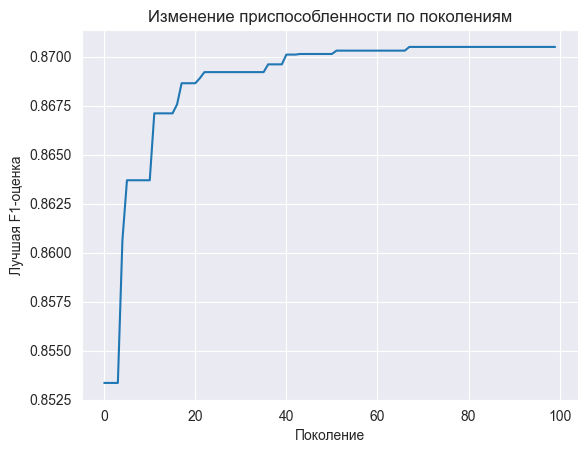

In [24]:
# Визуализация изменения приспособленности
plt.plot(ga.fitness_history)
plt.xlabel('Поколение')
plt.ylabel('Лучшая F1-оценка')
plt.title('Изменение приспособленности по поколениям')
plt.savefig('fitness_over_generations.png')
plt.show()